## Evaluation
This script evaluate the performance of trained models(CNN, ViT and ...) with ROC Curves and AUC scores.

Import necessary packages.

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from data_proc import LensDataset

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import seaborn as sns

import os
import sys


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from models import *

Load the trained model checkpoint and dataset.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load the trained model checkpoint
model = LensCNNClassifier(num_classes=3)  # Ensure this matches your architecture
model.load_state_dict(torch.load("../checkpoints/cnn/cnn_50epc_2025-03-11_17-18-29.pth"))
model.eval().to(device)

# Load dataset
val_path = "../dataset/val"
valset = LensDataset(val_path)
val_loader = DataLoader(valset, batch_size=64, shuffle=True)


Run inference on validation set.

In [4]:
# Prepare lists for storing true labels and predicted probabilities
y_true = []
y_scores = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # Get raw logits
        probs = F.softmax(outputs, dim=1).cpu().numpy()  # Convert logits to probabilities

        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probs)


Plot confusion matrix.

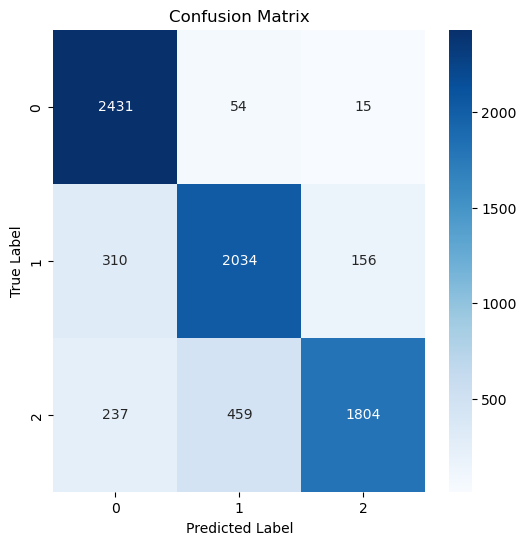

In [5]:
# Convert predicted probabilities to class predictions
y_pred_classes = np.argmax(y_scores, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, 2-y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

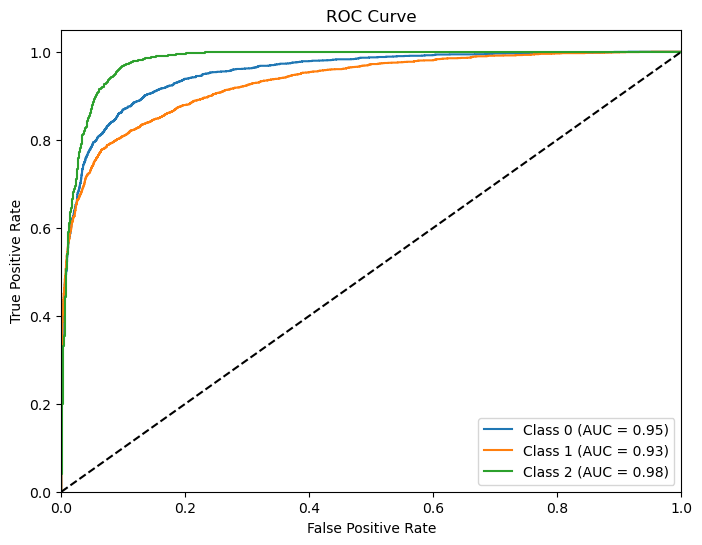

In [6]:
# Binarize labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=[2, 1, 0])

def view_results(y_true_bin, y_scores):
    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    for i in range(3):  # Loop through classes
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], np.array(y_scores)[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    # Plot random classifier line
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

view_results(y_true_bin, y_scores)

View evaluation results for ResCNN classifier.

In [7]:
# Load the trained model checkpoint
model = ResCNN(num_classes=3)  # Ensure this matches your architecture
model.load_state_dict(torch.load("../checkpoints/rescnn/rescnn_75epc_2025-03-16_17-19-40.pth"))
model.eval().to(device)

# Load dataset
val_path = "../dataset/val"
valset = LensDataset(val_path)
val_loader = DataLoader(valset, batch_size=64, shuffle=True)

In [8]:
y_true = []
y_scores = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # Get raw logits
        probs = F.softmax(outputs, dim=1).cpu().numpy()  # Convert logits to probabilities

        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probs)

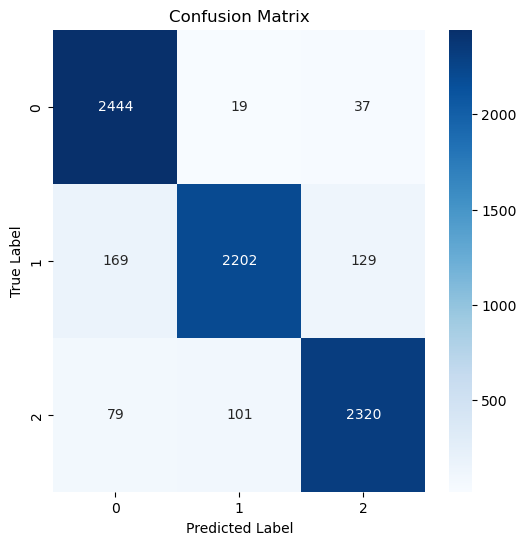

In [9]:
# Convert predicted probabilities to class predictions
y_pred_classes = np.argmax(y_scores, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, 2-y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

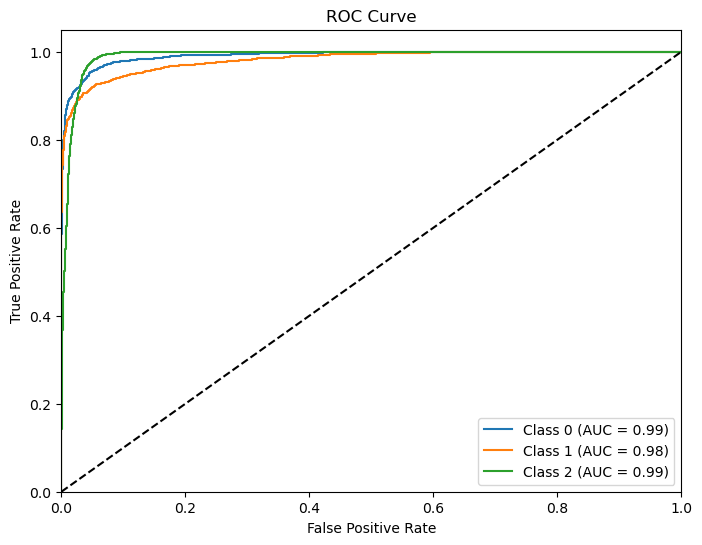

In [10]:
# Binarize labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=[2, 1, 0])

view_results(y_true_bin, y_scores)